In [53]:
import pandas as pd
import numpy as np

In [103]:
survey_April20 = pd.read_csv('Data/ProlificAcademic/April 2020/Data/CRISIS_Adult_April_2020.csv',index_col='ID')

In [104]:
survey_May20 = pd.read_csv('Data/ProlificAcademic/May 2020/Data/CRISIS_Adult_May_2020.csv',index_col='ID')

In [118]:
survey_Nov20 = pd.read_csv('Data/ProlificAcademic/November 2020/Data/CRISIS_Adult_November_2020.csv',index_col='ID')

In [108]:
survey_April21 = pd.read_csv('Data/ProlificAcademic/April 2021/Data/CRISIS_Adult_April_2021.csv',index_col='ID')

In [120]:
# check individual row and column dimensions
print(survey_April20.shape)
print(survey_May20.shape)
print(survey_Nov20.shape)
print(survey_April21.shape)

(1184, 242)
(1184, 108)
(2223, 289)
(2125, 284)


In [45]:
# cant use merge as columns are not same
# survey_df = pd.merge(survey_April20, survey_Nov20, how="inner", on='ID')

### Find common participants across all groups

In [121]:
series_1 = pd.Series(np.intersect1d(survey_April20.index,survey_May20.index, assume_unique=True))
series_2 = pd.Series(np.intersect1d(survey_Nov20.index,survey_April21.index, assume_unique=True))
unique_ids = list(pd.Series(np.intersect1d(series_1,series_2,assume_unique=True)))
#pd.Series(np.intersect1d(pd.Series([1,2,3,5,42]), pd.Series([4,5,6,20,42])))a

In [122]:
len(unique_ids)

1184

In [165]:
# Test entry in a dataframe
print('location' in survey_April20.columns)
survey_April21.loc['00db60f1','location']

True


4.0

In [126]:
## filter rows
survey_April20 = survey_April20.loc[unique_ids]
survey_May20 = survey_May20.loc[unique_ids]
survey_Nov20 = survey_Nov20.loc[unique_ids]
survey_April21 = survey_April21.loc[unique_ids]

In [143]:
## Compare shapes after filtering
print(survey_April20.shape)
print(survey_May20.shape)
print(survey_Nov20.shape)
print(survey_April21.shape)

(1184, 242)
(1184, 108)
(1184, 289)
(1184, 284)


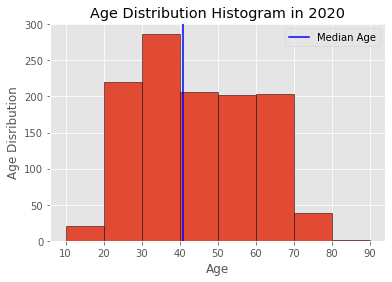

In [149]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
ages = survey_Nov20['age']
bins = list(range(10,100,10))
median_age = survey_Nov20['age'].median()
plt.hist(ages, bins=bins, edgecolor='black')
plt.axvline(median_age, color='blue', label="Median Age")
plt.xlabel("Age")
plt.ylabel("Age Disribution")
plt.title("Age Distribution Histogram in 2020")
plt.legend()
plt.show()

### List Common columns across All time whose data is unlikely to change - eg. gender,age,occupation, country etc.

<AxesSubplot:>

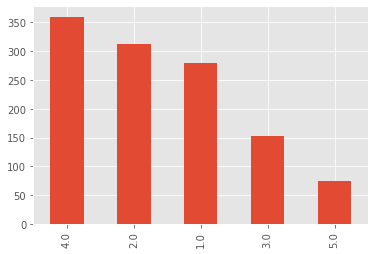

In [177]:
## bar graph of categorical variables - location, use start of survey April 20 data


survey_April20['location'].value_counts().plot(kind='bar')


<AxesSubplot:>

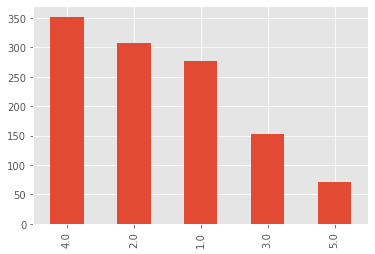

In [178]:
survey_April21['location'].value_counts().plot(kind='bar')